In [1]:
from my_methods import *
import requests
import io

In [2]:
dfE = pd.read_table('data/SGA_ExE.txt')
dfE = dfE.loc[dfE['P-value']<0.05]

dfN = pd.read_table('data/SGA_NxN.txt')
dfN = dfN.loc[dfN['P-value']<0.05]

dfEN = pd.read_table('data/SGA_ExN_NxE.txt')
dfEN = dfEN.loc[dfEN['P-value']<0.05]

df_global = pd.concat([dfE, dfN, dfEN])
df_global.reset_index(inplace=True)

In [3]:
dfE['Multiplicative Score'] = dfE['Double mutant fitness'] - (dfE['Query single mutant fitness (SMF)']*dfE['Array SMF'])
dfE['Additive Score'] = dfE['Double mutant fitness'] - (dfE['Query single mutant fitness (SMF)']+dfE['Array SMF']-1)
########################################################################################################################
dfN['Multiplicative Score'] = dfN['Double mutant fitness'] - (dfN['Query single mutant fitness (SMF)']*dfN['Array SMF'])
dfN['Additive Score'] = dfN['Double mutant fitness'] - (dfN['Query single mutant fitness (SMF)']+dfN['Array SMF']-1)
########################################################################################################################
df_global['Multiplicative Score'] = df_global['Double mutant fitness'] - (df_global['Query single mutant fitness (SMF)']*df_global['Array SMF'])
df_global['Additive Score'] = df_global['Double mutant fitness'] - (df_global['Query single mutant fitness (SMF)']+df_global['Array SMF']-1)

In [4]:
# def select_extreme_list(array, percentage=2.5):
#     array = copy.deepcopy(array)
#     array = sorted(array)
#     array0 = array[:int(len(array)*percentage/100)]
#     array1 = array[-int(len(array)*percentage/100):]
#     return np.concatenate([array0, array1])

In [5]:
# Normalizing values
mean_mul = np.nanmean(list(dfE['Multiplicative Score']))
mean_add = np.nanmean(list(dfE['Additive Score']))

dfE['Multiplicative Score'] = dfE['Multiplicative Score'].map(lambda x: x-mean_mul)
dfE['Additive Score'] = dfE['Additive Score'].map(lambda x: x-mean_add)

mean_mul = np.nanmean(list(dfN['Multiplicative Score']))
mean_add = np.nanmean(list(dfN['Additive Score']))

dfN['Multiplicative Score'] = dfN['Multiplicative Score'].map(lambda x: x-mean_mul)
dfN['Additive Score'] = dfN['Additive Score'].map(lambda x: x-mean_add)

mean_mul = np.nanmean(list(df_global['Multiplicative Score']))
mean_add = np.nanmean(list(df_global['Additive Score']))

df_global['Multiplicative Score'] = df_global['Multiplicative Score'].map(lambda x: x-mean_mul)
df_global['Additive Score'] = df_global['Additive Score'].map(lambda x: x-mean_add)

In [6]:
cond1_mul = abs(df_global['Multiplicative Score']) > 0.3
cond2_mul = abs(df_global['Additive Score']) < 0.3


filtered_mul = df_global.loc[cond1_mul & cond2_mul]
filtered_mul.reset_index(inplace=True)
filt_pairs_mul = set([tuple(sorted((filtered_mul.loc[i, 'Query allele name'], filtered_mul.loc[i, 'Array allele name']))) for i in range(len(filtered_mul))])
##### Sorting by name in each tuple of the list


################################################################

cond1_add = abs(df_global['Multiplicative Score']) < 0.3
cond2_add = abs(df_global['Additive Score']) > 0.3


filtered_add = df_global.loc[cond1_add & cond2_add]
filtered_add.reset_index(inplace=True)
filt_pairs_add = set([tuple(sorted((filtered_add.loc[i, 'Query allele name'], filtered_add.loc[i, 'Array allele name']))) for i in range(len(filtered_add))])
##### Sorting by name in each tuple of the list


print('Ignoradas en el add: ', len(filt_pairs_mul))
print('Ignoradas en el mul: ', len(filt_pairs_add))
### 3662 ignored by additive ><=
### 10267 ignored by multiplicative ><=

Ignoradas en el add:  3596
Ignoradas en el mul:  10176


In [7]:
len(filt_pairs_mul), len(filt_pairs_add)

(3596, 10176)

In [8]:
# Ignored by both models
cond1_ign = abs(df_global['Multiplicative Score']) < 0.3
cond2_ign = abs(df_global['Additive Score']) < 0.3


ignored_both = df_global.loc[cond1_ign & cond2_ign]
ignored_both.reset_index(inplace=True)
ignored_both = set([tuple(sorted((ignored_both.loc[i, 'Query allele name'], ignored_both.loc[i, 'Array allele name']))) for i in range(len(ignored_both))])
##### Sorting by name in each tuple of the list
len(ignored_both)

2211047

In [9]:
# Shared by both models
cond1_shared = abs(df_global['Multiplicative Score']) > 0.3
cond2_shared = abs(df_global['Additive Score']) > 0.3

shared_both = df_global.loc[cond1_shared & cond2_shared]
shared_both.reset_index(inplace=True)
shared_both = set([tuple(sorted((shared_both.loc[i, 'Query allele name'], shared_both.loc[i, 'Array allele name']))) for i in range(len(shared_both))])
##### Sorting by name in each tuple of the list
len(shared_both)

31238

In [18]:
def plt_color(mul_list, add_list, factor=1, std_values=None):
    values = list(zip(mul_list, add_list))
    if std_values==None:
        mul_std = np.nanstd(mul_list)
        add_std = np.nanstd(add_list)
    else:
        mul_std = std_values[0]
        add_std = std_values[1]
    colors = []
    for i in values:
        if i[0]<-factor*mul_std and i[1]>factor*add_std:
            colors.append('red')
        elif abs(i[0])<factor*mul_std and abs(i[1])>factor*add_std:
            colors.append('lime')
        elif abs(i[0])>factor*mul_std and abs(i[1])<factor*add_std:
            colors.append('green')
        elif abs(i[0])<factor*mul_std and abs(i[1])<factor*add_std:
            colors.append('lightgray')
        else: colors.append('black')
    return colors

# def count_values(mul_list, add_list, factor, select_extreme=False, percentage=2.5):
#     if select_extreme==True:
#         zipped = list(zip(mul_list, add_list))
#         ##########
#         zipped0 = zipped[:]
#         zipped0.sort(key=lambda x: x[0])
#         ##########
#         zipped1 = zipped[:]
#         zipped1.sort(key=lambda x: x[1])
#         ##########
#         z0 = zipped0[:int(len(zipped)*percentage/100)]
#         z0.extend(zipped0[-int(len(zipped)*percentage/100):])
#         ##########
#         z1 = zipped1[:int(len(zipped)*percentage/100)]
#         z1.extend(zipped1[-int(len(zipped)*percentage/100):])
#         ##########
#         z0 = set(z0)
#         z1 = set(z1)
#         z = z0.intersection(z1)
#         values = list(z)
#     else:
#         values = list(zip(mul_list, add_list))
#     mul_std = np.nanstd(mul_list)
#     add_std = np.nanstd(add_list)
#     opp = 0
#     missed_eM = 0
#     missed_eA = 0
#     no_int = 0
#     interacting = 0
#     for i in values:
#         if i[0]<-mul_std*factor and i[1]>add_std*factor:
#             opp += 1
#         elif abs(i[0])<mul_std*factor and abs(i[1])>add_std*factor:
#             missed_eM += 1
#         elif abs(i[0])>mul_std*factor and abs(i[1])<add_std*factor:
#             missed_eA += 1
#         elif abs(i[0])<mul_std*factor and abs(i[1])<add_std*factor:
#             no_int += 1
#         else: interacting += 1
#     return opp, missed_eM, missed_eA, no_int, interacting

def plot_difference(mul_list, add_list, factor=1, select_extreme=False, percentage=2.5, save=False, name='default.png'):
    mul_std = np.nanstd(mul_list)
    add_std = np.nanstd(add_list)
    plt.figure(figsize=(10,10))
    if select_extreme==False:
        plt.scatter(mul_list, add_list, c=plt_color(mul_list, add_list, factor), s=2, zorder=10, alpha=0.5)
    if select_extreme==True:
        zipped = list(zip(mul_list, add_list))
        ##########
        zipped0 = zipped[:]
        zipped0.sort(key=lambda x: x[0])
        ##########
        zipped1 = zipped[:]
        zipped1.sort(key=lambda x: x[1])
        ##########
        z0 = zipped0[:int(len(zipped)*percentage/100)]
        z0.extend(zipped0[-int(len(zipped)*percentage/100):])
        ##########
        z1 = zipped1[:int(len(zipped)*percentage/100)]
        z1.extend(zipped1[-int(len(zipped)*percentage/100):])
        ##########
        z0 = set(z0)
        z1 = set(z1)
        z = z0.intersection(z1)
        ##########
        mul = list(map(lambda x: x[0], z))
        add = list(map(lambda x: x[1], z))
        plt.scatter(mul, add, c=plt_color(mul, add, factor=1, std_values=[mul_std, add_std]), s=2, zorder=10, alpha=0.5)
    b=plt.xlabel("Multiplicative model", fontsize = 20)
    c=plt.ylabel("Additive", fontsize = 20)
    f=plt.axvline(color='black')
    g=plt.axhline(color='black')
    h=plt.axvline(-mul_std*factor, zorder=20, color='lightgrey', alpha=0.8)
    i=plt.axvline(mul_std*factor, zorder=20, color='lightgrey', alpha=0.8)
    j=plt.axhline(-add_std*factor, zorder=20, color='lightgrey', alpha=0.8)
    k=plt.axhline(add_std*factor, zorder=20, color='lightgrey', alpha=0.8)
    # d=plt.xticks(np.arange(-1.4,1.4,0.1))
    # e=plt.yticks(np.arange(-1.4,1.4,0.1))
    plt.grid(True)
    if save:
        plt.savefig('img/'+name)

# def plot_bars(mul_list, add_list, factor=1, select_extreme=False, percentage=2.5, save=False, name='default.png'):
#     labels = ['opposite sign', 'missed by eM', 'missed by eA', 'no interacting', 'interacting']
#     values = [*count_values(mul_list, add_list, factor, select_extreme, percentage)]
#     colors = ['red', 'lime', 'green', 'lightgrey', 'black']
#     zipped = list(zip(values, labels, colors))
#     zipped.sort(key=lambda x: x[0])
#     values = list(map(lambda x: x[0], zipped))
#     labels = list(map(lambda x: x[1], zipped))
#     colors = list(map(lambda x: x[2], zipped))
#     fig, ax = plt.subplots()
#     bars = ax.barh(labels, width=values, color=colors, height=0.8, edgecolor='black')
#     plt.yticks(fontsize=15)
#     plt.xticks(fontsize=10)
#     text = ax.bar_label(bars, fontsize=15)
#     if save:
#         plt.savefig('img/'+name)

In [21]:
def plt_color_value(mul_list, add_list, value):
    values = list(zip(mul_list, add_list))
    colors = []
    for i in values:
        mul = abs(i[0])
        add = abs(i[1])
        if mul<value and add<value:
            colors.append('gray')
        elif mul>value and add<value:
            colors.append('green')
        elif mul>value and add>value:
            colors.append('black')
        else: colors.append('lime')
    return colors

In [ ]:
def plot_difference_value(mul_list, add_list, value, save=False, name='default.png'):
    plt.figure(figsize=(10,10))
    plt.scatter(mul_list, add_list, c=plt_color_value(mul_list, add_list, value), s=2, zorder=10, alpha=0.5)
    b=plt.xlabel("Modelo multiplicativo", fontsize = 15)
    c=plt.ylabel("Modelo aditivo", fontsize = 15)
    f=plt.axvline(color='black')
    g=plt.axhline(color='black')
    h=plt.axvline(-value, zorder=20, color='lightgrey', alpha=0.8)
    i=plt.axvline(value, zorder=20, color='lightgrey', alpha=0.8)
    j=plt.axhline(-value, zorder=20, color='lightgrey', alpha=0.8)
    k=plt.axhline(value, zorder=20, color='lightgrey', alpha=0.8)
    d=plt.xticks(np.arange(-1.4,1.4,0.2), fontsize=16)
    e=plt.yticks(np.arange(-1.4,1.4,0.2), fontsize=16)
    plt.grid(True)
    plt.text(0.5, 0.5, '6 inches x 2 inches')
    if save:
        plt.savefig(name)

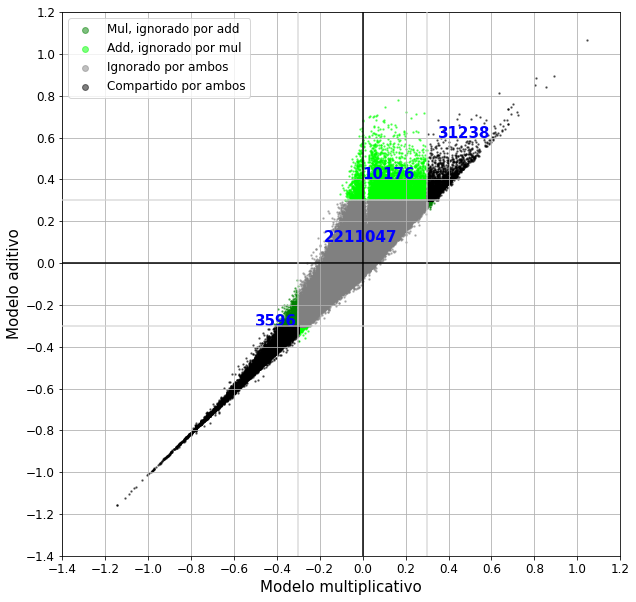

In [31]:
plt.figure(figsize=(10,10))

value=0.3
df = df_global[['Multiplicative Score', 'Additive Score']]

green = df.loc[(abs(df['Multiplicative Score'])>value) & (abs(df['Additive Score'])<value)]
plt.scatter(green['Multiplicative Score'], green['Additive Score'], c='green', label='Mul, ignored by add', s=2, alpha=0.5)

lime = df.loc[(abs(df['Multiplicative Score'])<value) & (abs(df['Additive Score'])>value)]
plt.scatter(lime['Multiplicative Score'], lime['Additive Score'], c='lime', label='Add, ignored by mul', s=2, alpha=0.5)

gray = df.loc[(abs(df['Multiplicative Score'])<value) & (abs(df['Additive Score'])<value)]
plt.scatter(gray['Multiplicative Score'], gray['Additive Score'], c='gray', label='Ignored by both', s=2, alpha=0.5)

black = df.loc[(abs(df['Multiplicative Score'])>value) & (abs(df['Additive Score'])>value)]
plt.scatter(black['Multiplicative Score'], black['Additive Score'], c='black', label='Shared by both', s=2, alpha=0.5)

b=plt.xlabel('Multiplicative model', fontsize = 15)
c=plt.ylabel('Additive model', fontsize = 15)
f=plt.axvline(color='black')
g=plt.axhline(color='black')
h=plt.axvline(-value, zorder=20, color='lightgrey', alpha=0.8)
i=plt.axvline(value, zorder=20, color='lightgrey', alpha=0.8)
j=plt.axhline(-value, zorder=20, color='lightgrey', alpha=0.8)
k=plt.axhline(value, zorder=20, color='lightgrey', alpha=0.8)
d=plt.xticks(np.arange(-1.4,1.4,0.2), fontsize=12)
e=plt.yticks(np.arange(-1.4,1.4,0.2), fontsize=12)
plt.grid(True)
a = plt.text(-0.18, 0.1, f'{len(ignored_both)}', fontweight='bold', c='blue', fontsize=15)
a = plt.text(0, 0.4, f'{len(filt_pairs_add)}', fontweight='bold', c='blue', fontsize=15)
a = plt.text(-0.5, -0.3, f'{len(filt_pairs_mul)}', fontweight='bold', c='blue', fontsize=15)
a = plt.text(0.35, 0.6, f'{len(shared_both)}', fontweight='bold', c='blue', fontsize=15)

leg = plt.legend(fontsize=12)
leg.legendHandles[0]._sizes = [35]
leg.legendHandles[1]._sizes = [35]
leg.legendHandles[2]._sizes = [35]
leg.legendHandles[3]._sizes = [35]

plt.savefig('img/values_comparison.png')

In [27]:
import statsmodels.api as sm

In [28]:
selected = df_global[(df_global['Multiplicative Score']<-0.3) & (df_global['Additive Score']<-0.3)]
x = list(selected['Multiplicative Score'])
y = list(selected['Additive Score'])

In [30]:
0.9894200785358205**2

0.9789520918098291

In [26]:
print(stats.linregress(x,y))

LinregressResult(slope=1.0143331039828605, intercept=0.003952501865356894, rvalue=0.9894200785358205, pvalue=0.0, stderr=0.000834480608202851, intercept_stderr=0.0003673333258380163)


In [29]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.478e+06
Date:                Fri, 04 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:14:53   Log-Likelihood:                 84862.
No. Observations:               31769   AIC:                        -1.697e+05
Df Residuals:                   31767   BIC:                        -1.697e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.000     10.760      0.0

In [30]:
# def count_values_with_cutoff(mul_list, add_list, value):
#     values = list(zip(mul_list, add_list))
#     mul_std = np.nanstd(mul_list)
#     add_std = np.nanstd(add_list)
#     opp = 0
#     missed_eM = 0
#     missed_eA = 0
#     no_int = 0
#     interacting = 0
#     for i in values:
#         mul = abs(i[0])
#         add = abs(i[1])
#         if mul<value and add<value:
#             no_int+=1
#         elif mul>value and add<value:
#             missed_eA+=1
#         elif mul>value and add>value:
#             interacting+=1
#         else: missed_eM+=1
#     return opp, missed_eM, missed_eA, no_int, interacting


# def plot_bars_value(mul_list, add_list, value, save=False, name='default.png'):
#     labels = ['opposite sign', 'missed by eM', 'missed by eA', 'no interacting', 'interacting']
#     values = [*count_values_with_cutoff(mul_list, add_list, value)]
#     colors = ['red', 'lime', 'green', 'lightgrey', 'black']
#     zipped = list(zip(values, labels, colors))
#     zipped.sort(key=lambda x: x[0])
#     values = list(map(lambda x: x[0], zipped))
#     labels = list(map(lambda x: x[1], zipped))
#     colors = list(map(lambda x: x[2], zipped))
#     fig, ax = plt.subplots()
#     bars = ax.barh(labels, width=values, color=colors, height=0.8, edgecolor='black')
#     plt.yticks(fontsize=15)
#     plt.xticks(fontsize=10)
#     text = ax.bar_label(bars, fontsize=15)
#     if save:
#         plt.savefig(+name)

In [1]:
# plot_bars_value(list(df_global['Multiplicative Score']), list(df_global['Additive Score']), value=0.3)

In [53]:
# Process gene names to pass them to STRING
filt_pairs_add = list(map(lambda x: (x[0].split('-')[0].upper(), x[1].split('-')[0].upper()), filt_pairs_add))
filt_pairs_mul = list(map(lambda x: (x[0].split('-')[0].upper(), x[1].split('-')[0].upper()), filt_pairs_mul))

In [56]:
count = 0
coincidences = []
exceptions = []
filt_tables = 0.7
for tup in filt_pairs_add:
    try:
        response = requests.get(f'https://string-db.org/api/tsv/interaction_partners?identifiers={tup[0]}&species=4932&limit=100')
        table = pd.read_table(io.StringIO(response.content.decode('utf-8')))
        df = table.loc[table['score']>filt_tables]
        interactors = list(df['preferredName_B'])
        if tup[1] in interactors:
            coincidences.append(tup)
        count += 1
        print('Round: ', count, f'/{len(filt_pairs_add)}', '   Coincidences: ', len(coincidences), end='\r')
    except:
        exceptions.append(tup)
## Round:  10166 /10176    Coincidences:  392   ->  3.85%

In [57]:
count = 0
coincidences = []
exceptions = []
filt_tables = 0.7
for tup in filt_pairs_mul:
    try:
        response = requests.get(f'https://string-db.org/api/tsv/interaction_partners?identifiers={tup[0]}&species=4932&limit=100')
        table = pd.read_table(io.StringIO(response.content.decode('utf-8')))
        df = table.loc[table['score']>filt_tables]
        interactors = list(df['preferredName_B'])
        if tup[1] in interactors:
            coincidences.append(tup)
        count += 1
        print('Round: ', count, f'/{len(filt_pairs_mul)}', '   Coincidences: ', len(coincidences), end='\r')
    except:
        exceptions.append(tup)
# Round:  3593 /3596    Coincidences:  503   ->  13.98%